<a href="https://colab.research.google.com/github/tombackert/CS411-ml-for-ds/blob/main/Project_4_MNIST_NN_tensorflow_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [3]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),  # 784
  tf.keras.layers.Dense(128, activation='relu'),  # 128
  tf.keras.layers.Dense(64, activation='relu'),   # 64
  tf.keras.layers.Dense(10)                       # 10
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.6028 - sparse_categorical_accuracy: 0.8283 - val_loss: 0.1640 - val_sparse_categorical_accuracy: 0.9530
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.1467 - sparse_categorical_accuracy: 0.9575 - val_loss: 0.1190 - val_sparse_categorical_accuracy: 0.9648
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1001 - sparse_categorical_accuracy: 0.9705 - val_loss: 0.0939 - val_sparse_categorical_accuracy: 0.9709
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9782 - val_loss: 0.0910 - val_sparse_categorical_accuracy: 0.9706
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0565 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0892 - val_sparse_categorical_accuracy: 0.9737
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0463 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.0744 - val_sparse_categorical_accuracy: 0.9767
Epoch 7/20
4

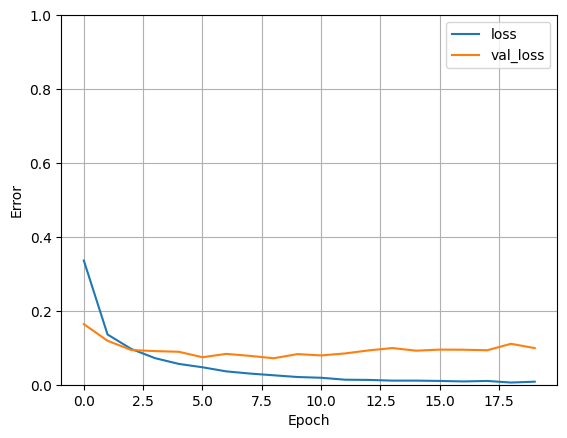

In [6]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# Q2: Diffrent Model Testing

In [7]:
### Automate testing of diffrent models

def create_model(hidden_layers, neurons_per_layer):
    """
    Function for creating new model with num of hidden layers and nerons per layer as parameter
    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    for neurons in neurons_per_layer:
        model.add(tf.keras.layers.Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(10))
    return model

def compile_model(model):
    """
    Function for compiling model
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

def plot_metrics(history, model_number):
    """
    Function for plotting metrics of model
    """

    """
    # Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title(f'Modell {model_number}: Genauigkeit')
    plt.xlabel('Epoche')
    plt.ylabel('Genauigkeit')
    plt.legend()
    plt.grid(True)
    plt.show()
    """

    # Loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Modell {model_number}: Verlust')
    plt.xlabel('Epoche')
    plt.ylabel('Verlust')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# Creating all three models

model1 = create_model(hidden_layers=1, neurons_per_layer=[128])
model2 = create_model(hidden_layers=2, neurons_per_layer=[128, 64])
model3 = create_model(hidden_layers=3, neurons_per_layer=[256, 128, 64])

In [9]:
# Compiling all three models

compile_model(model1)
compile_model(model2)
compile_model(model3)

In [10]:
import time
# Training all three models

# Model 1
start_time1 = time.time()
history1 = model1.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)
end_time1 = time.time()
training_time1 = end_time1 - start_time1
print(training_time1)

# Model 2
start_time2 = time.time()
history2 = model2.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)
end_time2 = time.time()
training_time2 = end_time2 - start_time2
print(training_time2)

# Model 3
start_time3 = time.time()
history3 = model3.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)
end_time3 = time.time()
training_time3 = end_time3 - start_time3
print(training_time3)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6071 - sparse_categorical_accuracy: 0.8343 - val_loss: 0.1966 - val_sparse_categorical_accuracy: 0.9436
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.1354 - val_sparse_categorical_accuracy: 0.9616
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1230 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.1063 - val_sparse_categorical_accuracy: 0.9674
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0924 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.0940 - val_sparse_categorical_accuracy: 0.9705
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0714 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0836 - val_sparse_categorical_accuracy: 0.9738
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0597 - sparse_categorical_accuracy: 0.9831 - val_loss: 0.0854 - val_sparse_categorical_accuracy: 0.9733
Epoc

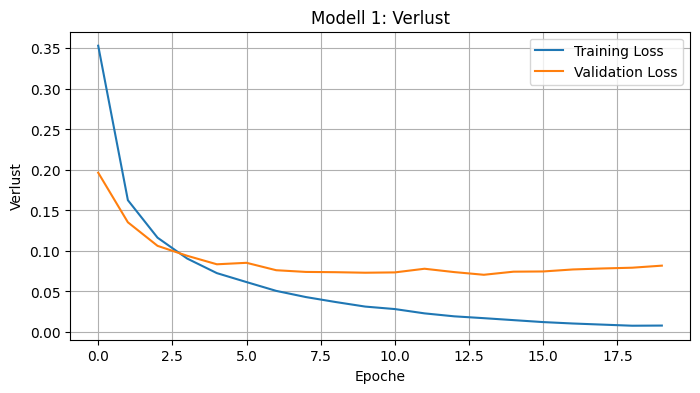

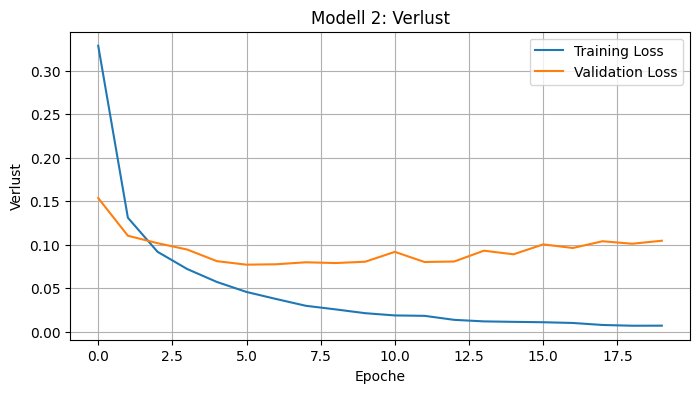

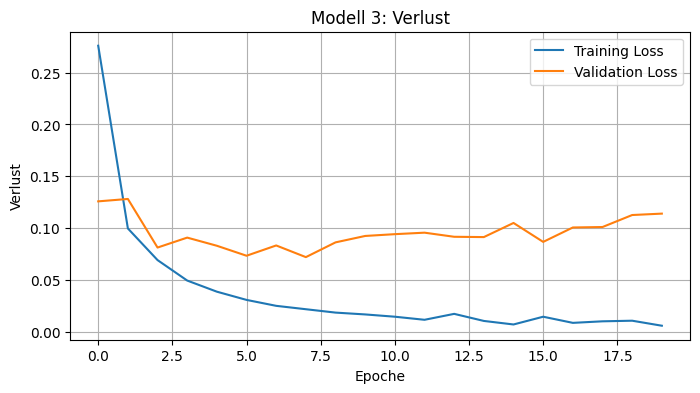

In [11]:
# Plotting loss
plot_metrics(history1, 1)
plot_metrics(history2, 2)
plot_metrics(history3, 3)

In [12]:
import time

def evaluate_model(model, ds_test, time):
    test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)
    return test_loss, test_accuracy, time

In [13]:
loss1, acc1, time1 = evaluate_model(model1, ds_test, training_time1)
loss2, acc2, time2 = evaluate_model(model2, ds_test, training_time2)
loss3, acc3, time3 = evaluate_model(model3, ds_test, training_time3)

In [14]:
print(training_time1)

60.40465545654297


In [15]:
import pandas as pd

results = pd.DataFrame({
    'Modell': ['Modell 1', 'Modell 2', 'Modell 3'],
    'Accuracy': [acc1, acc2, acc3],
    'Loss': [loss1, loss2, loss3],
    'Training Time (s)': [time1, time2, time3]
})

print(results)

     Modell  Accuracy      Loss  Training Time (s)
0  Modell 1    0.9773  0.081876          60.404655
1  Modell 2    0.9768  0.104567          57.971104
2  Modell 3    0.9773  0.113972         105.346649


# Q3: Hyperparameter Testing

In [16]:
def train_model(learning_rate, batch_size, epochs):
    # Create a new instance of the model
    model = create_model(hidden_layers=2, neurons_per_layer=[128, 64])


    # Compile the model with the specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
    )

    # Unbatch and re-batch the data to change the batch size
    ds_train_batched = ds_train.unbatch().batch(batch_size)
    ds_test_batched = ds_test.unbatch().batch(batch_size)

    # Record the training time
    start_time = time.time()
    history = model.fit(
        ds_train_batched,
        epochs=epochs,
        validation_data=ds_test_batched,
        verbose=1
    )
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(ds_test_batched, verbose=0)

    return {
        'model': model,
        'history': history,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs': epochs,
        'training_time': training_time,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }

In [17]:
result_lr_0_1 = train_model(learning_rate=0.1, batch_size=128, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    460/Unknown 5s 7ms/step - loss: 12.1190 - sparse_categorical_accuracy: 0.1047

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 12.1221 - sparse_categorical_accuracy: 0.1046 - val_loss: 12.3055 - val_sparse_categorical_accuracy: 0.1010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 12.2917 - sparse_categorical_accuracy: 0.1019 - val_loss: 12.3055 - val_sparse_categorical_accuracy: 0.1010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 12.2721 - sparse_categorical_accuracy: 0.1022 - val_loss: 12.3055 - val_sparse_categorical_accuracy: 0.1010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 12.3149 - sparse_categorical_accuracy: 0.1019 - val_loss: 12.3055 - val_sparse_categorical_accuracy: 0.1010
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 12.2650 - sparse_categorical_accuracy: 0.1033 - val_loss: 12.3055 - val_sparse_categorical_accuracy: 0.1010
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 12.2964 - sparse_categorical_accuracy: 0.1040 - val_loss: 12.3055 - val_sparse_categorical_accuracy: 0.1010
Epo

In [18]:
result_lr_0_01 = train_model(learning_rate=0.01, batch_size=128, epochs=10)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.6394 - sparse_categorical_accuracy: 0.1152 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0986
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0957 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0986
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0953 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0986
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0978 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0986
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0999 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0986
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0971 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.0986
Epo

In [19]:
result_lr_0_001 = train_model(learning_rate=0.001, batch_size=128, epochs=10)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6598 - sparse_categorical_accuracy: 0.2133 - val_loss: 2.1845 - val_sparse_categorical_accuracy: 0.2269
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2593 - sparse_categorical_accuracy: 0.1909 - val_loss: 2.2411 - val_sparse_categorical_accuracy: 0.2015
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2369 - sparse_categorical_accuracy: 0.2005 - val_loss: 2.2883 - val_sparse_categorical_accuracy: 0.1655
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.2640 - sparse_categorical_accuracy: 0.1795 - val_loss: 2.3024 - val_sparse_categorical_accuracy: 0.1058
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.3025 - sparse_categorical_accuracy: 0.1038 - val_loss: 2.3024 - val_sparse_categorical_accuracy: 0.1058
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3024 - sparse_categorical_accuracy: 0.1037 - val_loss: 2.3024 - val_sparse_categorical_accuracy: 0.1058
Epoc

In [20]:
# Create a DataFrame to store the results
lr_results = pd.DataFrame({
    'Learning Rate': [result_lr_0_1['learning_rate'], result_lr_0_01['learning_rate'], result_lr_0_001['learning_rate']],
    'Test Accuracy': [result_lr_0_1['test_accuracy'], result_lr_0_01['test_accuracy'], result_lr_0_001['test_accuracy']],
    'Test Loss': [result_lr_0_1['test_loss'], result_lr_0_01['test_loss'], result_lr_0_001['test_loss']],
    'Training Time (s)': [result_lr_0_1['training_time'], result_lr_0_01['training_time'], result_lr_0_001['training_time']]
})

print(lr_results)

   Learning Rate  Test Accuracy  Test Loss  Training Time (s)
0          0.100         0.1010  12.305525          52.340573
1          0.010         0.0986   2.302583          40.433019
2          0.001         0.1658   2.172720          37.541142


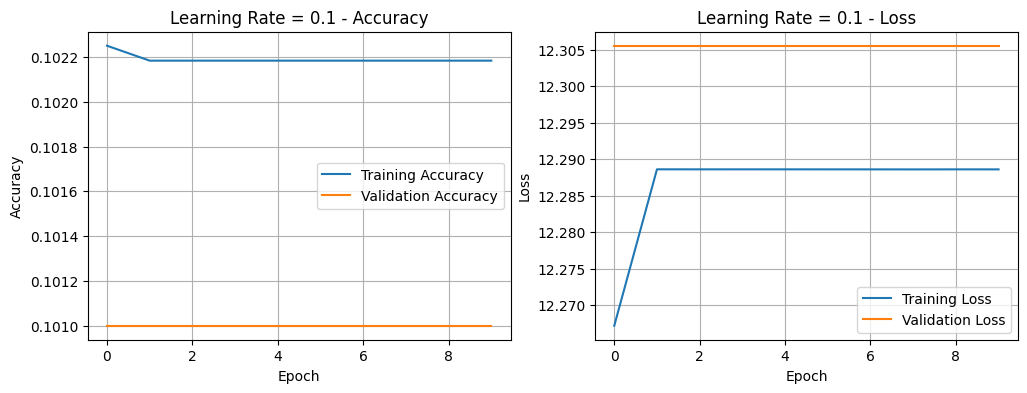

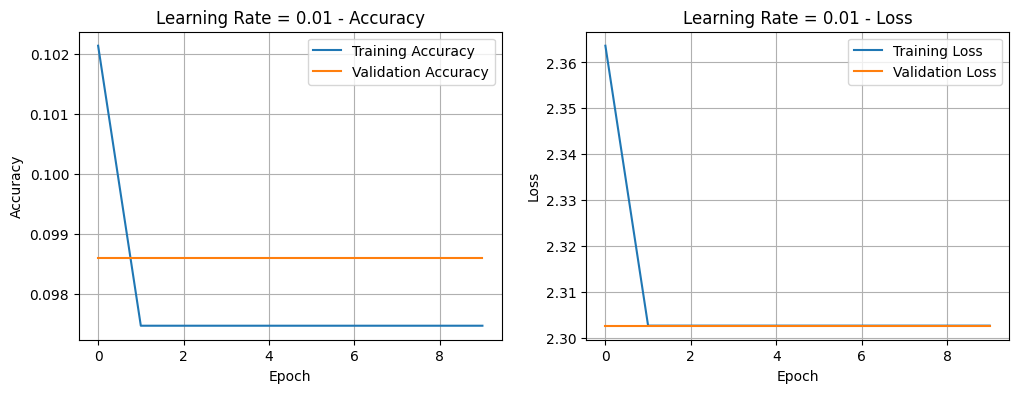

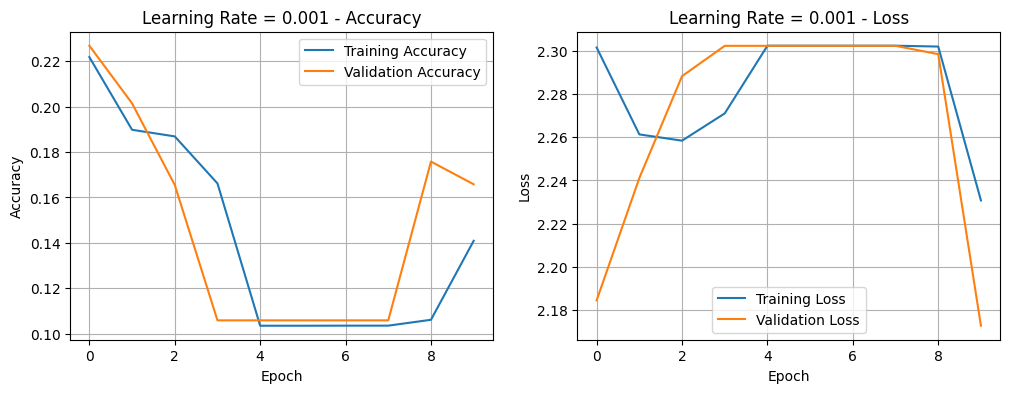

In [21]:
def plot_learning_curve(history, title):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Plot for each learning rate
plot_learning_curve(result_lr_0_1['history'], 'Learning Rate = 0.1')
plot_learning_curve(result_lr_0_01['history'], 'Learning Rate = 0.01')
plot_learning_curve(result_lr_0_001['history'], 'Learning Rate = 0.001')

In [22]:
# Epochs = 10
result_epochs_10 = train_model(learning_rate=0.01, batch_size=128, epochs=10)

# Epochs = 20
result_epochs_20 = train_model(learning_rate=0.01, batch_size=128, epochs=20)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


    469/Unknown 5s 7ms/step - loss: 2.8545 - sparse_categorical_accuracy: 0.2339

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 2.8537 - sparse_categorical_accuracy: 0.2338 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1517
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1483 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1517
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1473 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1517
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1482 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1517
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1487 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1517
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1497 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1517
Epoch 7/10
469/

In [23]:
# Batch Size = 64
result_batch_64 = train_model(learning_rate=0.01, batch_size=64, epochs=10)

# Batch Size = 128
result_batch_128 = train_model(learning_rate=0.01, batch_size=128, epochs=10)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 6.8423 - sparse_categorical_accuracy: 0.2334 - val_loss: 9.0392 - val_sparse_categorical_accuracy: 0.2713
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.2944 - sparse_categorical_accuracy: 0.2261 - val_loss: 9.4822 - val_sparse_categorical_accuracy: 0.2649
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.2448 - sparse_categorical_accuracy: 0.2814 - val_loss: 9.2733 - val_sparse_categorical_accuracy: 0.2581
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 9.9725 - sparse_categorical_accuracy: 0.2430 - val_loss: 13.1641 - val_sparse_categorical_accuracy: 0.1378
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 8.9973 - sparse_categorical_accuracy: 0.2329 - val_loss: 7.7696 - val_sparse_categorical_accuracy: 0.3261
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.5432 - sparse_categorical_accuracy: 0.2895 - val_loss: 9.2455 - val_sparse_categorical_accuracy: 0.2282
Epo

In [24]:
epoch_results = pd.DataFrame({
    'Epochs': [result_epochs_10['epochs'], result_epochs_20['epochs']],
    'Test Accuracy': [result_epochs_10['test_accuracy'], result_epochs_20['test_accuracy']],
    'Test Loss': [result_epochs_10['test_loss'], result_epochs_20['test_loss']],
    'Training Time (s)': [result_epochs_10['training_time'], result_epochs_20['training_time']]
})

print(epoch_results)

   Epochs  Test Accuracy  Test Loss  Training Time (s)
0      10         0.1517   2.302583          39.240076
1      20         0.0956   2.302583          77.566485


In [25]:
batch_results = pd.DataFrame({
    'Batch Size': [result_batch_64['batch_size'], result_batch_128['batch_size']],
    'Test Accuracy': [result_batch_64['test_accuracy'], result_batch_128['test_accuracy']],
    'Test Loss': [result_batch_64['test_loss'], result_batch_128['test_loss']],
    'Training Time (s)': [result_batch_64['training_time'], result_batch_128['training_time']]
})

print(batch_results)

   Batch Size  Test Accuracy  Test Loss  Training Time (s)
0          64         0.2052   8.925978          55.795235
1         128         0.3430   7.123194          43.930399


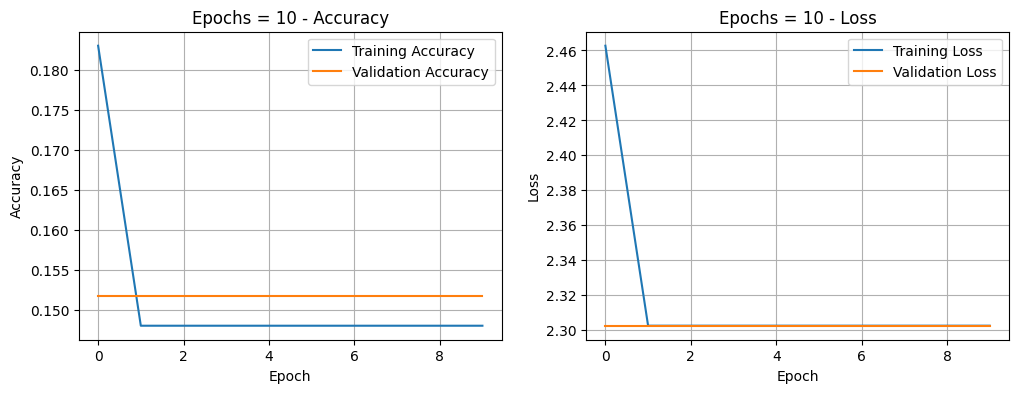

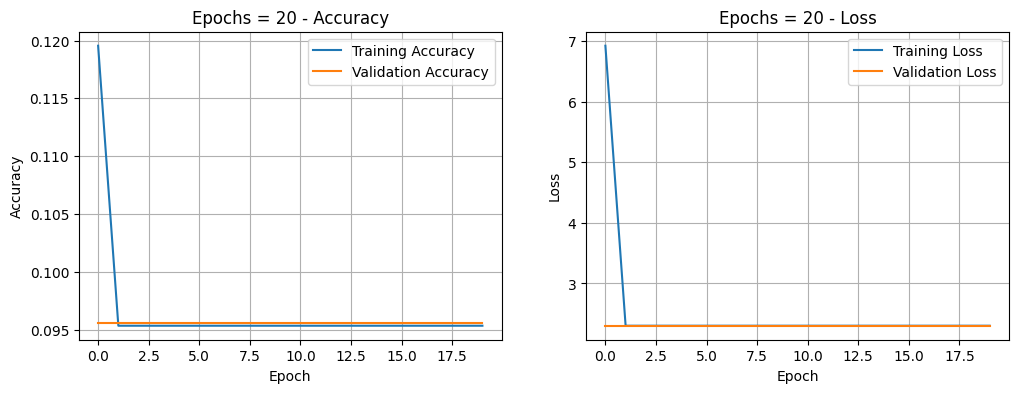

In [26]:
plot_learning_curve(result_epochs_10['history'], 'Epochs = 10')
plot_learning_curve(result_epochs_20['history'], 'Epochs = 20')

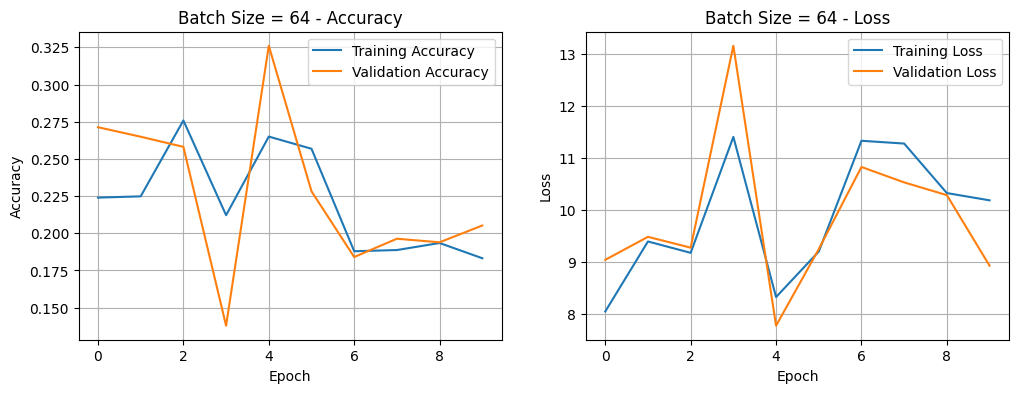

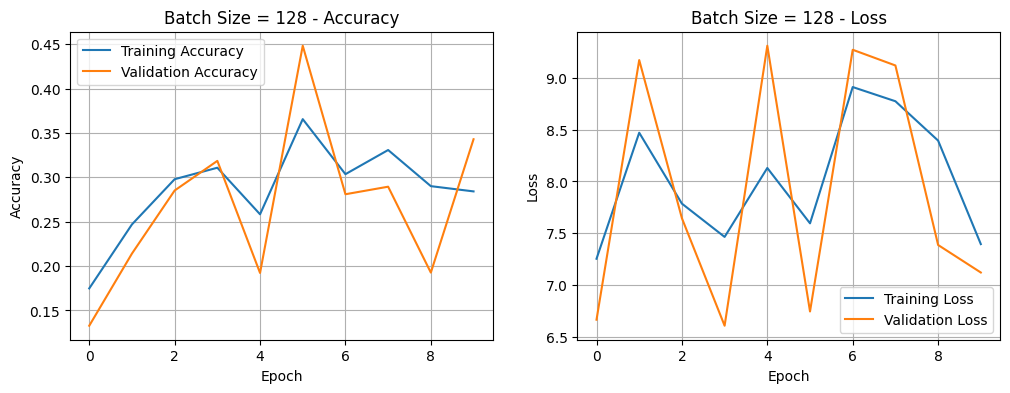

In [27]:
plot_learning_curve(result_batch_64['history'], 'Batch Size = 64')
plot_learning_curve(result_batch_128['history'], 'Batch Size = 128')

# Q4: Building a NN for a different Dataset


In [28]:
from tensorflow.keras.datasets import cifar10

In [29]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [30]:
# Check the shapes
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [31]:
# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

def create_cifar_model():
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

In [33]:
model = create_cifar_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
# Record training time
start_time = time.time()

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 2.2834 - sparse_categorical_accuracy: 0.1491 - val_loss: 1.9928 - val_sparse_categorical_accuracy: 0.2778
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 2.0408 - sparse_categorical_accuracy: 0.2144 - val_loss: 1.9845 - val_sparse_categorical_accuracy: 0.2957
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 2.0120 - sparse_categorical_accuracy: 0.2330 - val_loss: 1.9503 - val_sparse_categorical_accuracy: 0.2874
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 1.9830 - sparse_categorical_accuracy: 0.2444 - val_loss: 1.9616 - val_sparse_categorical_accuracy: 0.2786
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 1.9752 - sparse_categorical_accuracy: 0.2465 - val_loss: 1.9281 - val_sparse_categorical_accuracy: 0.3191
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - loss: 1.9577 - sparse_categorical_accuracy: 0.2614 - val_loss: 1.9445 - val_sparse_categorical_accuracy:

In [36]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

Test Loss: 1.9024
Test Accuracy: 0.3220
Training Time: 293.93 seconds


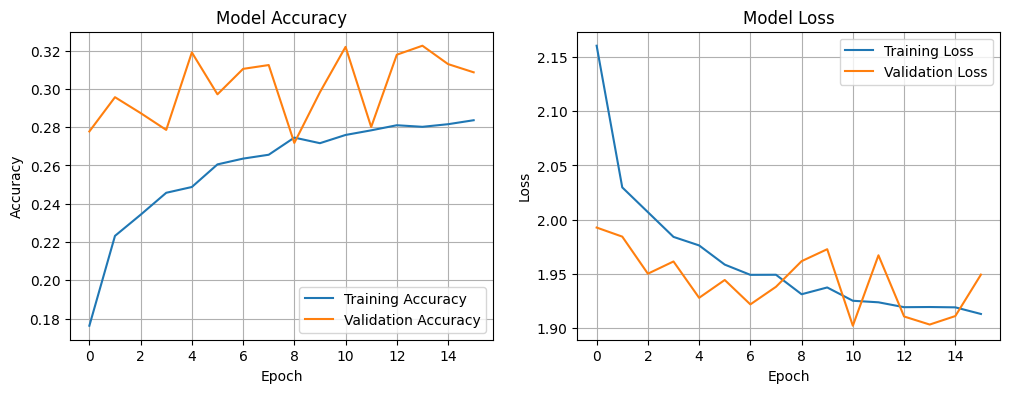

In [37]:
def plot_learning_curves(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_learning_curves(history)